# POS词性标注（BILSTM和BiGRU）

# Load POS data and Preprocessing 

In [164]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing Function

In [85]:
PAD, UNK = '<pad>', '<unk>'

### Data padding function

In [265]:
def pad_data(sentences, labels, word2idx):
    assert len(sentences)==len(labels)
    assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
    max_len = np.max([len(sentence) for sentence in sentences]) # Find out how much to pad
    padded_sentences  = list()
    padded_labels  = list()
    for sentence, tags in zip(sentences, labels):               # Loop over the data
        padded_sentence = [word.lower() if word.lower() in word2idx else UNK for word in sentence]  # Sentence, uses the <UNK> symbol for unknown words
        padded_tags = [tag for tag in tags]                       # Tags
        padded_sentence += [PAD] * max(max_len - len(padded_sentence), 0)
        padded_tags += [PAD] * max(max_len - len(padded_tags), 0)
        padded_sentences.append(padded_sentence)                  # Append the processed sample to the output
        padded_labels.append(padded_tags)
    return padded_sentences, padded_labels

### Data encoding function

In [87]:
def encode_data(padded_sentences, padded_labels, word2idx, tag2idx, use_cuda):
    encoded_sentences = [[word2idx[word] for word in line] for line in padded_sentences]
    encoded_labels = [[tag2idx[tag] for tag in line] for line in padded_labels]
    if use_cuda:
        encoded_sentences = torch.cuda.LongTensor(encoded_sentences)
        encoded_labels = torch.cuda.LongTensor(encoded_labels)
    else:
        encoded_sentences = torch.LongTensor(encoded_sentences)
        encoded_labels = torch.LongTensor(encoded_labels)
    return encoded_sentences, encoded_labels

### Data batchify function

We input the whole dataset into the `batchify` function and then this function will generate mini-batch data.

In [274]:
def batchify(word_data, pos_data, batch_size, word2idx, tag2idx, use_cuda):
    num_sent = len(word_data)
    num_batch = num_sent // batch_size
    for i in range(num_batch):
        sents, labels = pad_data(word_data[i*batch_size:(i+1)*batch_size], pos_data[i*batch_size:(i+1)*batch_size],
                                 word2idx)
        yield encode_data(sents, labels, word2idx, tag2idx, use_cuda)
    if num_sent % batch_size:
        sents, labels = pad_data(word_data[num_batch*batch_size:], pos_data[num_batch*batch_size:],
                                 word2idx)
        yield encode_data(sents, labels, word2idx, tag2idx, use_cuda)

## Model Evaluation Function

We use this function to evaluate our models.

In [131]:
def eva(model, sentences, tags, word2idx, tag2idx, use_cuda):
    total, correct = 0, 0
    for sent, tag in zip(sentences, tags):
        sent = torch.LongTensor([word2idx[word.lower()] if word.lower() in word2idx else word2idx[UNK] for word in sent])
        tag = [tag2idx[t] for t in tag]
        if use_cuda:
            sent = sent.to('cuda')
        pred = model.predict(sent)
        if use_cuda:
            pred = pred.cpu().numpy()
        for i in range(len(tag)):
            if tag[i] == pred[i]:
                correct += 1
            total += 1
    return correct / total

## Simplified Chinese POS data

### Training data reading

In [284]:
with open('UDzhPOS/zh_gsdsimp-ud-train.txt', encoding='utf-8') as f:
    lines = f.readlines()
zh_word_data = []
zh_pos_data = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        zh_word_data.append(word_sent)
        zh_pos_data.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in zh_word_data:
    if line != []:
        tmp.append(line)
zh_word_data = tmp
tmp = []
for line in zh_pos_data:
    if line != []:
        tmp.append(line)
zh_pos_data = tmp

### Testing data reading

In [285]:
with open('UDzhPOS/zh_gsdsimp-ud-test.txt', encoding='utf-8') as f:
    lines = f.readlines()
zh_word_test = []
zh_pos_test = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        zh_word_test.append(word_sent)
        zh_pos_test.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in zh_word_test:
    if line != []:
        tmp.append(line)
zh_word_test = tmp
tmp = []
for line in zh_pos_test:
    if line != []:
        tmp.append(line)
zh_pos_test = tmp

### Validation data reading

In [286]:
with open('UDzhPOS/zh_gsdsimp-ud-dev.txt', encoding='utf-8') as f:
    lines = f.readlines()
zh_word_dev = []
zh_pos_dev = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        zh_word_dev.append(word_sent)
        zh_pos_dev.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in zh_word_dev:
    if line != []:
        tmp.append(line)
zh_word_dev = tmp
tmp = []
for line in zh_pos_dev:
    if line != []:
        tmp.append(line)
zh_pos_dev = tmp

### Data preprocessing

Build the word vocabulary and pos tagging vocabulary:

In [46]:
zh_voc = list(set([word for line in word_data for word in line])) + [PAD] + [UNK]
zh_pos_voc = list(set([tag for line in pos_data for tag in line])) + [PAD] + [UNK]
zh_w2i = {word: idx for idx, word in enumerate(zh_voc)}
zh_pos2i = {tag: idx for idx, tag in enumerate(zh_pos_voc)}

# RNN Model

In [123]:
class RNNPOS(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, use_gru,
                bidirectional, out_dim, word2idx, dropout_rate=0):
        super(RNNPOS, self).__init__()
        self.w2i = word2idx
        # Embedding layer
        self.embed = nn.Embedding(num_embeddings=vocab_size,
                                 embedding_dim=embedding_dim,
                                 padding_idx=word2idx[PAD])
        self.use_gru = use_gru
        if use_gru:
            # use_gru = True
            # we use gru rnn.
            self.rnn = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size,
                             num_layers=num_layers, bidirectional=bidirectional,
                             dropout=dropout_rate)
        else:
            # use_gru = False
            # we use LSTM rnn
            self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,
                              num_layers=num_layers, bidirectional=bidirectional,
                              dropout=dropout_rate)
        self.bi = bidirectional
        if self.bi:
            self.proj = nn.Linear(2 * hidden_size, out_dim)
        else:
            self.proj = nn.Linear(hidden_size, out_dim)
        self.dropout = nn.Dropout(p=dropout_rate)
    
    def forward(self, sentences):
        """
        sentences: [batch_size, max_seq_len]
        """
        embed_x = self.embed(sentences).permute(1, 0, 2) # [max_seq_len, batch_size, embed_dim]
        lengths = torch.sum(sentences != self.w2i[PAD], dim=-1) # [batch_size]
        pack_x = nn.utils.rnn.pack_padded_sequence(embed_x, lengths, enforce_sorted=False)
        pack_output, _ = self.rnn(pack_x)
        output = nn.utils.rnn.pad_packed_sequence(pack_output)[0] # [seq_len, batch_size, num_directions * hidden_size]
        output = self.proj(self.dropout(output)).permute(1, 0, 2) # [batch_size, seq_len, out_dim]
        return output
    
    def compute_loss(self, sentences, tags):
        """
        We use this function to compute the cross entropy loss.
        sentences: [batch_size, max_seq_len]
        tags: [batch_size, max_seq_len]
        """
        batch_size, seq_len = sentences.shape
        # we use sent_mask to cover the padding index.
        sent_mask = (sentences != self.w2i[PAD]).contiguous().view(batch_size * seq_len, -1) # [batch_size * seq_len, out_dim]
        output = self.forward(sentences) # [batch_size, seq_len, out_dim]
        output = output.contiguous().view(batch_size * seq_len, -1) # [batch_size * seq_len, out_dim]
        loss = nn.functional.cross_entropy(output, tags.view(-1), reduction='none') * sent_mask.to(torch.float32)
        return loss.mean()
        
    def predict(self, sentence):
        """
        We use this function to predict the tag of sentence.
        sentence: [seq_len]
        """
        sentence = sentence.unsqueeze(0) # [1, seq_len]
        output = self.forward(sentence).squeeze(0) # [seq_len, out_dim]
        tag = torch.argmax(output, dim=-1) # [seq_len]
        return tag

# Simplified Chinese POS Data Experiment

## Hyper-parameters

In [133]:
vocab_size = len(zh_voc)
embedding_dim = 100
hidden_size = 100
num_layers = 2
learning_rate = 0.001
num_epoch = 50
batch_size = 32
out_dim = len(zh_pos_voc)
word2idx = zh_w2i
tag2idx = zh_pos2i
use_cuda = True

## Single Direction GRU Model

### Model Config

In [98]:
use_gru = True
bidirectional = False

In [135]:
singleGRU = RNNPOS(vocab_size, embedding_dim, hidden_size, num_layers, use_gru,
                    bidirectional, out_dim, word2idx, dropout_rate=0).to(device)
optimizer = torch.optim.Adam(singleGRU.parameters(), lr=learning_rate)

### Model Traning

In [136]:
best_acc = 0
for epoch in range(num_epoch):
    total_loss = 0.
    for sentences, tags in batchify(zh_word_data, zh_pos_data, batch_size, word2idx, tag2idx, use_cuda):
        optimizer.zero_grad()
        loss = singleGRU.compute_loss(sentences, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    dev_acc = eva(singleGRU, zh_word_dev, zh_pos_dev, zh_w2i, zh_pos2i, use_cuda)
    if dev_acc >= best_acc:
        best_acc = dev_acc
        torch.save(singleGRU.state_dict(), 'singleGRU.pt')
        print(f"Epoch: {epoch+1}/{num_epoch}. Total Loss: {total_loss:.3f}. Dev Acc: {dev_acc:.2%}.")
    else:
        print("Early Stop!")
        break

Epoch: 1/50. Total Loss: 123.868. Dev Acc: 55.88%.
Epoch: 2/50. Total Loss: 100.481. Dev Acc: 65.85%.
Epoch: 3/50. Total Loss: 88.198. Dev Acc: 70.19%.
Epoch: 4/50. Total Loss: 78.145. Dev Acc: 72.88%.
Epoch: 5/50. Total Loss: 69.236. Dev Acc: 74.80%.
Epoch: 6/50. Total Loss: 61.170. Dev Acc: 76.15%.
Epoch: 7/50. Total Loss: 53.829. Dev Acc: 76.94%.
Epoch: 8/50. Total Loss: 47.185. Dev Acc: 77.46%.
Epoch: 9/50. Total Loss: 41.242. Dev Acc: 77.80%.
Early Stop!


### Model Testing

In [137]:
test_acc = eva(singleGRU, zh_word_test, zh_pos_test, zh_w2i, zh_pos2i, use_cuda)
print(f"Test Set Accuracy: {test_acc:.3%}")

Test Set Accuracy: 77.567%


## Bidirectional GRU Model

### Model Config

In [138]:
use_gru = True
bidirectional = True

In [147]:
biGRU = RNNPOS(vocab_size, embedding_dim, hidden_size, num_layers, use_gru,
               bidirectional, out_dim, word2idx, dropout_rate=0).to(device)
optimizer = torch.optim.Adam(biGRU.parameters(), lr=learning_rate)

### Module Training

In [148]:
best_acc = 0
for epoch in range(num_epoch):
    total_loss = 0.
    for sentences, tags in batchify(zh_word_data, zh_pos_data, batch_size, word2idx, tag2idx, use_cuda):
        optimizer.zero_grad()
        loss = biGRU.compute_loss(sentences, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    dev_acc = eva(biGRU, zh_word_dev, zh_pos_dev, zh_w2i, zh_pos2i, use_cuda)
    if dev_acc >= best_acc:
        best_acc = dev_acc
        torch.save(biGRU.state_dict(), 'biGRU.pt')
        print(f"Epoch: {epoch+1}/{num_epoch}. Total Loss: {total_loss:.3f}. Dev Acc: {dev_acc:.2%}.")
    else:
        print("Early Stop!")
        break

Epoch: 1/50. Total Loss: 114.259. Dev Acc: 62.17%.
Epoch: 2/50. Total Loss: 92.377. Dev Acc: 69.81%.
Epoch: 3/50. Total Loss: 80.607. Dev Acc: 73.72%.
Epoch: 4/50. Total Loss: 70.808. Dev Acc: 75.65%.
Epoch: 5/50. Total Loss: 62.142. Dev Acc: 76.94%.
Epoch: 6/50. Total Loss: 54.371. Dev Acc: 77.58%.
Epoch: 7/50. Total Loss: 47.460. Dev Acc: 77.95%.
Epoch: 8/50. Total Loss: 41.427. Dev Acc: 78.01%.
Early Stop!


### Model Testing

In [149]:
test_acc = eva(biGRU, zh_word_test, zh_pos_test, zh_w2i, zh_pos2i, use_cuda)
print(f"Test Set Accuracy: {test_acc:.3%}")

Test Set Accuracy: 78.117%


## Single Direction LSTM Model

### Model Config

In [151]:
use_gru = False
bidirectional = False

In [152]:
singleLSTM = RNNPOS(vocab_size, embedding_dim, hidden_size, num_layers, use_gru,
                    bidirectional, out_dim, word2idx, dropout_rate=0).to(device)
optimizer = torch.optim.Adam(singleLSTM.parameters(), lr=learning_rate)

### Model Training

In [153]:
best_acc = 0
for epoch in range(num_epoch):
    total_loss = 0.
    for sentences, tags in batchify(zh_word_data, zh_pos_data, batch_size, word2idx, tag2idx, use_cuda):
        optimizer.zero_grad()
        loss = singleLSTM.compute_loss(sentences, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    dev_acc = eva(singleLSTM, zh_word_dev, zh_pos_dev, zh_w2i, zh_pos2i, use_cuda)
    if dev_acc >= best_acc:
        best_acc = dev_acc
        torch.save(singleLSTM.state_dict(), 'singleLSTM.pt')
        print(f"Epoch: {epoch+1}/{num_epoch}. Total Loss: {total_loss:.3f}. Dev Acc: {dev_acc:.2%}.")
    else:
        print("Early Stop!")
        break

Epoch: 1/50. Total Loss: 121.429. Dev Acc: 55.48%.
Epoch: 2/50. Total Loss: 98.156. Dev Acc: 65.75%.
Epoch: 3/50. Total Loss: 85.749. Dev Acc: 70.64%.
Epoch: 4/50. Total Loss: 75.736. Dev Acc: 73.52%.
Epoch: 5/50. Total Loss: 66.936. Dev Acc: 75.31%.
Epoch: 6/50. Total Loss: 59.000. Dev Acc: 76.49%.
Epoch: 7/50. Total Loss: 51.806. Dev Acc: 77.26%.
Epoch: 8/50. Total Loss: 45.319. Dev Acc: 77.75%.
Epoch: 9/50. Total Loss: 39.530. Dev Acc: 77.78%.
Early Stop!


### Model Testing

In [154]:
test_acc = eva(singleLSTM, zh_word_test, zh_pos_test, zh_w2i, zh_pos2i, use_cuda)
print(f"Test Set Accuracy: {test_acc:.3%}")

Test Set Accuracy: 77.458%


## Bidirectional LSTM Model

### Model Config

In [155]:
use_gru = False
bidirectional = True

In [156]:
biLSTM = RNNPOS(vocab_size, embedding_dim, hidden_size, num_layers, use_gru,
               bidirectional, out_dim, word2idx, dropout_rate=0).to(device)
optimizer = torch.optim.Adam(biLSTM.parameters(), lr=learning_rate)

### Model Training

In [157]:
best_acc = 0
for epoch in range(num_epoch):
    total_loss = 0.
    for sentences, tags in batchify(zh_word_data, zh_pos_data, batch_size, word2idx, tag2idx, use_cuda):
        optimizer.zero_grad()
        loss = biLSTM.compute_loss(sentences, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    dev_acc = eva(biLSTM, zh_word_dev, zh_pos_dev, zh_w2i, zh_pos2i, use_cuda)
    if dev_acc >= best_acc:
        best_acc = dev_acc
        torch.save(biLSTM.state_dict(), 'biLSTM.pt')
        print(f"Epoch: {epoch+1}/{num_epoch}. Total Loss: {total_loss:.3f}. Dev Acc: {dev_acc:.2%}.")
    else:
        print("Early Stop!")
        break

Epoch: 1/50. Total Loss: 118.636. Dev Acc: 57.82%.
Epoch: 2/50. Total Loss: 93.972. Dev Acc: 68.43%.
Epoch: 3/50. Total Loss: 81.003. Dev Acc: 73.35%.
Epoch: 4/50. Total Loss: 70.841. Dev Acc: 75.77%.
Epoch: 5/50. Total Loss: 62.059. Dev Acc: 77.21%.
Epoch: 6/50. Total Loss: 54.311. Dev Acc: 78.02%.
Epoch: 7/50. Total Loss: 47.581. Dev Acc: 78.07%.
Epoch: 8/50. Total Loss: 41.453. Dev Acc: 78.26%.
Epoch: 9/50. Total Loss: 36.127. Dev Acc: 78.93%.
Early Stop!


### Model Testing

In [158]:
test_acc = eva(biLSTM, zh_word_test, zh_pos_test, zh_w2i, zh_pos2i, use_cuda)
print(f"Test Set Accuracy: {test_acc:.3%}")

Test Set Accuracy: 79.043%


## Model Comparasion

In section 3.2~3.5, we train 4 different models, including single direction GRU, bidirectional GRU, single direction LSTM and bidirectional LSTM. From the table below, we can find that bidirectional LSTM model is the best model.

In [159]:
import pandas as pd
pd.DataFrame([0.77567, 0.78117, 0.77458, 0.79043], index = ['singleGRU', 'biGRU', 'singleLSTM', 'biLSTM'], columns=['test acc'])

,test acc
singleGRU,0.77567
biGRU,0.78117
singleLSTM,0.77458
biLSTM,0.79043


## Dropout

We use biLSTM model with different dropout value to find the effect of dropout.

In [161]:
use_gru = False
bidirectional = True

In [170]:
print("Begin Training!")
dropout_rate = [0, 0.2, 0.4, 0.6, 0.8]
test_acc_list = []
for dp in dropout_rate:
    biLSTM = RNNPOS(vocab_size, embedding_dim, hidden_size, num_layers, use_gru,
               bidirectional, out_dim, word2idx, dropout_rate=dp).to(device)
    optimizer = torch.optim.Adam(biLSTM.parameters(), lr=learning_rate)
    # Model Training
    best_acc = 0.
    for epoch in range(num_epoch):
        total_loss = 0.
        for sentences, tags in batchify(zh_word_data, zh_pos_data, batch_size, word2idx, tag2idx, use_cuda):
            optimizer.zero_grad()
            loss = biLSTM.compute_loss(sentences, tags)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        dev_acc = eva(biLSTM, zh_word_dev, zh_pos_dev, zh_w2i, zh_pos2i, use_cuda)
        if dev_acc >= best_acc:
            best_acc = dev_acc
        else:
            break
    
    # Model evaluation
    test_acc = eva(biLSTM, zh_word_test, zh_pos_test, zh_w2i, zh_pos2i, use_cuda)
    test_acc_list.append(test_acc)
print("Finish!")

Begin Training!
Finish!


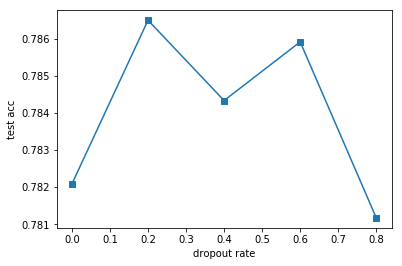

In [173]:
plt.plot(dropout_rate, test_acc_list, marker='s')
plt.xlabel('dropout rate')
plt.ylabel('test acc')
plt.show()

From the graph above, we can find that when `dropout_rate = 0.2`, biLSTM model has the highest accuracy.

# Other Language POS Data Experiment

We test the biLSTM model in 4 other different languages, including English, Japanese, Korean and Portuguese.

## English POS Data Experiment

### English POS Data Loading

Training data:

In [206]:
with open('UDenPOS/en_ewt-ud-train.txt', encoding='utf-8') as f:
    lines = f.readlines()
en_word_data = []
en_pos_data = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        en_word_data.append(word_sent)
        en_pos_data.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in en_word_data:
    if line != []:
        tmp.append(line)
en_word_data = tmp
tmp = []
for line in en_pos_data:
    if line != []:
        tmp.append(line)
en_pos_data = tmp

Testing data:

In [210]:
with open('UDenPOS/en_ewt-ud-test.txt', encoding='utf-8') as f:
    lines = f.readlines()
en_word_test = []
en_pos_test = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        en_word_test.append(word_sent)
        en_pos_test.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in en_word_test:
    if line != []:
        tmp.append(line)
en_word_test = tmp
tmp = []
for line in en_pos_test:
    if line != []:
        tmp.append(line)
en_pos_test = tmp

Validation data:

In [211]:
with open('UDenPOS/en_ewt-ud-dev.txt', encoding='utf-8') as f:
    lines = f.readlines()
en_word_dev = []
en_pos_dev = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        en_word_dev.append(word_sent)
        en_pos_dev.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in en_word_dev:
    if line != []:
        tmp.append(line)
en_word_dev = tmp
tmp = []
for line in en_pos_dev:
    if line != []:
        tmp.append(line)
en_pos_dev = tmp

Vocabulary:

In [214]:
en_voc = list(set([word for line in en_word_data for word in line])) + [PAD] + [UNK]
en_pos_voc = list(set([tag for line in en_pos_data for tag in line])) + [PAD] + [UNK]
en_w2i = {word: idx for idx, word in enumerate(en_voc)}
en_pos2i = {tag: idx for idx, tag in enumerate(en_pos_voc)}

### Model Training

In [217]:
# Hyperparameter
embedding_dim = 100
hidden_size = 100
num_layers = 2
learning_rate = 0.001
num_epoch = 50
batch_size = 32
use_cuda = True
word2idx = en_w2i
tag2idx = en_pos2i
vocab_size = len(en_voc)
out_dim = len(en_pos_voc)

In [216]:
biLSTM = RNNPOS(vocab_size, embedding_dim, hidden_size, num_layers, False,
               True, out_dim, word2idx, dropout_rate=0.2).to(device)
optimizer = torch.optim.Adam(biLSTM.parameters(), lr=learning_rate)
best_acc = 0
for epoch in range(num_epoch):
    total_loss = 0.
    for sentences, tags in batchify(en_word_data, en_pos_data, batch_size, word2idx, tag2idx, use_cuda):
        optimizer.zero_grad()
        loss = biLSTM.compute_loss(sentences, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    dev_acc = eva(biLSTM, en_word_dev, en_pos_dev, en_w2i, en_pos2i, use_cuda)
    if dev_acc >= best_acc:
        best_acc = dev_acc
        torch.save(biLSTM.state_dict(), 'enbiLSTM.pt')
        print(f"Epoch: {epoch+1}/{num_epoch}. Total Loss: {total_loss:.3f}. Dev Acc: {dev_acc:.2%}.")
    else:
        print("Early Stop!")
        break

Epoch: 1/50. Total Loss: 275.552. Dev Acc: 79.83%.
Epoch: 2/50. Total Loss: 185.352. Dev Acc: 84.63%.
Epoch: 3/50. Total Loss: 130.085. Dev Acc: 86.60%.
Epoch: 4/50. Total Loss: 89.610. Dev Acc: 87.30%.
Epoch: 5/50. Total Loss: 61.671. Dev Acc: 87.60%.
Epoch: 6/50. Total Loss: 43.304. Dev Acc: 87.93%.
Epoch: 7/50. Total Loss: 31.246. Dev Acc: 88.26%.
Epoch: 8/50. Total Loss: 23.186. Dev Acc: 88.39%.
Epoch: 9/50. Total Loss: 17.546. Dev Acc: 88.81%.
Early Stop!


### Model Testing

In [218]:
test_acc = eva(biLSTM, en_word_test, en_pos_test, en_w2i, en_pos2i, use_cuda)
print(f"Test Set Accuracy: {test_acc:.3%}")

Test Set Accuracy: 89.013%


## Japanese POS Data Experiment

### Japanese POS Data Loading

Training data:

In [232]:
with open('UDjaPOS/ja_gsd-ud-train.txt', encoding='utf-8') as f:
    lines = f.readlines()
ja_word_data = []
ja_pos_data = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        ja_word_data.append(word_sent)
        ja_pos_data.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in ja_word_data:
    if line != []:
        tmp.append(line)
ja_word_data = tmp
tmp = []
for line in ja_pos_data:
    if line != []:
        tmp.append(line)
ja_pos_data = tmp

Testing data:

In [221]:
with open('UDjaPOS/ja_gsd-ud-test.txt', encoding='utf-8') as f:
    lines = f.readlines()
ja_word_test = []
ja_pos_test = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        ja_word_test.append(word_sent)
        ja_pos_test.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in ja_word_test:
    if line != []:
        tmp.append(line)
ja_word_test = tmp
tmp = []
for line in ja_pos_test:
    if line != []:
        tmp.append(line)
ja_pos_test = tmp

Validation data:

In [222]:
with open('UDjaPOS/ja_gsd-ud-dev.txt', encoding='utf-8') as f:
    lines = f.readlines()
ja_word_dev = []
ja_pos_dev = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        ja_word_dev.append(word_sent)
        ja_pos_dev.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in ja_word_dev:
    if line != []:
        tmp.append(line)
ja_word_dev = tmp
tmp = []
for line in ja_pos_dev:
    if line != []:
        tmp.append(line)
ja_pos_dev = tmp

Vocabulary:

In [234]:
ja_voc = list(set([word for line in ja_word_data for word in line])) + [PAD] + [UNK]
ja_pos_voc = list(set([tag for line in ja_pos_data for tag in line])) + [PAD] + [UNK]
ja_w2i = {word: idx for idx, word in enumerate(ja_voc)}
ja_pos2i = {tag: idx for idx, tag in enumerate(ja_pos_voc)}

### Model Training

In [236]:
# Hyperparameter
embedding_dim = 100
hidden_size = 100
num_layers = 2
learning_rate = 0.001
num_epoch = 50
batch_size = 32
use_cuda = True
word2idx = ja_w2i
tag2idx = ja_pos2i
vocab_size = len(ja_voc)
out_dim = len(ja_pos_voc)

In [237]:
biLSTM = RNNPOS(vocab_size, embedding_dim, hidden_size, num_layers, False,
               True, out_dim, word2idx, dropout_rate=0.2).to(device)
optimizer = torch.optim.Adam(biLSTM.parameters(), lr=learning_rate)
best_acc = 0
for epoch in range(num_epoch):
    total_loss = 0.
    for sentences, tags in batchify(ja_word_data, ja_pos_data, batch_size, word2idx, tag2idx, use_cuda):
        optimizer.zero_grad()
        loss = biLSTM.compute_loss(sentences, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    dev_acc = eva(biLSTM, ja_word_dev, ja_pos_dev, ja_w2i, ja_pos2i, use_cuda)
    if dev_acc >= best_acc:
        best_acc = dev_acc
        torch.save(biLSTM.state_dict(), 'jabiLSTM.pt')
        print(f"Epoch: {epoch+1}/{num_epoch}. Total Loss: {total_loss:.3f}. Dev Acc: {dev_acc:.2%}.")
    else:
        print("Early Stop!")
        break

Epoch: 1/50. Total Loss: 175.774. Dev Acc: 83.98%.
Epoch: 2/50. Total Loss: 134.665. Dev Acc: 87.38%.
Epoch: 3/50. Total Loss: 111.396. Dev Acc: 88.50%.
Epoch: 4/50. Total Loss: 91.170. Dev Acc: 89.55%.
Epoch: 5/50. Total Loss: 73.588. Dev Acc: 89.84%.
Epoch: 6/50. Total Loss: 58.703. Dev Acc: 90.42%.
Epoch: 7/50. Total Loss: 46.596. Dev Acc: 90.79%.
Epoch: 8/50. Total Loss: 37.010. Dev Acc: 91.29%.
Epoch: 9/50. Total Loss: 29.481. Dev Acc: 91.56%.
Epoch: 10/50. Total Loss: 23.634. Dev Acc: 91.96%.
Epoch: 11/50. Total Loss: 19.155. Dev Acc: 92.23%.
Early Stop!


### Model Testing

In [238]:
test_acc = eva(biLSTM, ja_word_test, ja_pos_test, ja_w2i, ja_pos2i, use_cuda)
print(f"Test Set Accuracy: {test_acc:.3%}")

Test Set Accuracy: 90.895%


## Korean POS Data Experiment

### Korean POS Data Loading

Training data:

In [239]:
with open('UDkoPOS/ko_gsd-ud-train.txt', encoding='utf-8') as f:
    lines = f.readlines()
ko_word_data = []
ko_pos_data = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        ko_word_data.append(word_sent)
        ko_pos_data.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in ko_word_data:
    if line != []:
        tmp.append(line)
ko_word_data = tmp
tmp = []
for line in ko_pos_data:
    if line != []:
        tmp.append(line)
ko_pos_data = tmp

Testing data:

In [241]:
with open('UDkoPOS/ko_gsd-ud-test.txt', encoding='utf-8') as f:
    lines = f.readlines()
ko_word_test = []
ko_pos_test = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        ko_word_test.append(word_sent)
        ko_pos_test.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in ko_word_test:
    if line != []:
        tmp.append(line)
ko_word_test = tmp
tmp = []
for line in ko_pos_test:
    if line != []:
        tmp.append(line)
ko_pos_test = tmp

Validation data:

In [242]:
with open('UDkoPOS/ko_gsd-ud-dev.txt', encoding='utf-8') as f:
    lines = f.readlines()
ko_word_dev = []
ko_pos_dev = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        ko_word_dev.append(word_sent)
        ko_pos_dev.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in ko_word_dev:
    if line != []:
        tmp.append(line)
ko_word_dev = tmp
tmp = []
for line in ko_pos_dev:
    if line != []:
        tmp.append(line)
ko_pos_dev = tmp

Vocabulary:

In [243]:
ko_voc = list(set([word for line in ko_word_data for word in line])) + [PAD] + [UNK]
ko_pos_voc = list(set([tag for line in ko_pos_data for tag in line])) + [PAD] + [UNK]
ko_w2i = {word: idx for idx, word in enumerate(ko_voc)}
ko_pos2i = {tag: idx for idx, tag in enumerate(ko_pos_voc)}

### Model Training

In [244]:
# Hyperparameter
embedding_dim = 100
hidden_size = 100
num_layers = 2
learning_rate = 0.001
num_epoch = 50
batch_size = 32
use_cuda = True
word2idx = ko_w2i
tag2idx = ko_pos2i
vocab_size = len(ko_voc)
out_dim = len(ko_pos_voc)

In [246]:
biLSTM = RNNPOS(vocab_size, embedding_dim, hidden_size, num_layers, False,
               True, out_dim, word2idx, dropout_rate=0.2).to(device)
optimizer = torch.optim.Adam(biLSTM.parameters(), lr=learning_rate)
best_acc = 0
for epoch in range(num_epoch):
    total_loss = 0.
    for sentences, tags in batchify(ko_word_data, ko_pos_data, batch_size, word2idx, tag2idx, use_cuda):
        optimizer.zero_grad()
        loss = biLSTM.compute_loss(sentences, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    dev_acc = eva(biLSTM, ko_word_dev, ko_pos_dev, ko_w2i, ko_pos2i, use_cuda)
    if dev_acc >= best_acc:
        best_acc = dev_acc
        torch.save(biLSTM.state_dict(), 'kobiLSTM.pt')
        print(f"Epoch: {epoch+1}/{num_epoch}. Total Loss: {total_loss:.3f}. Dev Acc: {dev_acc:.2%}.")
    else:
        print("Early Stop!")
        break

Epoch: 1/50. Total Loss: 110.084. Dev Acc: 58.53%.
Epoch: 2/50. Total Loss: 95.124. Dev Acc: 62.50%.
Epoch: 3/50. Total Loss: 84.601. Dev Acc: 65.94%.
Epoch: 4/50. Total Loss: 74.557. Dev Acc: 69.60%.
Epoch: 5/50. Total Loss: 65.203. Dev Acc: 71.54%.
Epoch: 6/50. Total Loss: 56.553. Dev Acc: 72.01%.
Epoch: 7/50. Total Loss: 48.740. Dev Acc: 73.78%.
Epoch: 8/50. Total Loss: 42.114. Dev Acc: 74.54%.
Early Stop!


### Model Testing

In [247]:
test_acc = eva(biLSTM, ko_word_test, ko_pos_test, ko_w2i, ko_pos2i, use_cuda)
print(f"Test Set Accuracy: {test_acc:.3%}")

Test Set Accuracy: 76.380%


## Portuguese POS Data Loading

### Portuguese POS Data Loading

Training data:

In [267]:
with open('UDptPOS/pt_gsd-ud-train.txt', encoding='utf-8') as f:
    lines = f.readlines()
pt_word_data = []
pt_pos_data = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        pt_word_data.append(word_sent)
        pt_pos_data.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in pt_word_data:
    if line != []:
        tmp.append(line)
pt_word_data = tmp
tmp = []
for line in pt_pos_data:
    if line != []:
        tmp.append(line)
pt_pos_data = tmp

Testing data:

In [269]:
with open('UDptPOS/pt_gsd-ud-test.txt', encoding='utf-8') as f:
    lines = f.readlines()
pt_word_test = []
pt_pos_test = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        pt_word_test.append(word_sent)
        pt_pos_test.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in pt_word_test:
    if line != []:
        tmp.append(line)
pt_word_test = tmp
tmp = []
for line in pt_pos_test:
    if line != []:
        tmp.append(line)
pt_pos_test = tmp

Validation data:

In [270]:
with open('UDptPOS/pt_gsd-ud-dev.txt', encoding='utf-8') as f:
    lines = f.readlines()
pt_word_dev = []
pt_pos_dev = []
word_sent = []
pos_sent = []
for line in lines:
    if '#' not in line and line != '\n':
        line = line.replace('\t', ' ').replace('\n', '').split(' ')
        word_sent.append(line[1])
        pos_sent.append(line[3])
    elif "sent_id" in line:
        pt_word_dev.append(word_sent)
        pt_pos_dev.append(pos_sent)
        word_sent, pos_sent = [], []
tmp = []
for line in pt_word_dev:
    if line != []:
        tmp.append(line)
pt_word_dev = tmp
tmp = []
for line in pt_pos_dev:
    if line != []:
        tmp.append(line)
pt_pos_dev = tmp

Vocabulary:

In [271]:
pt_voc = list(set([word for line in pt_word_data for word in line])) + [PAD] + [UNK]
pt_pos_voc = list(set([tag for line in pt_pos_data for tag in line])) + [PAD] + [UNK]
pt_w2i = {word: idx for idx, word in enumerate(pt_voc)}
pt_pos2i = {tag: idx for idx, tag in enumerate(pt_pos_voc)}

### Model Training

In [272]:
# Hyperparameter
embedding_dim = 100
hidden_size = 100
num_layers = 2
learning_rate = 0.001
num_epoch = 50
batch_size = 32
use_cuda = True
word2idx = pt_w2i
tag2idx = pt_pos2i
vocab_size = len(pt_voc)
out_dim = len(pt_pos_voc)

In [275]:
biLSTM = RNNPOS(vocab_size, embedding_dim, hidden_size, num_layers, False,
               True, out_dim, word2idx, dropout_rate=0.2).to(device)
optimizer = torch.optim.Adam(biLSTM.parameters(), lr=learning_rate)
best_acc = 0
for epoch in range(num_epoch):
    total_loss = 0.
    for sentences, tags in batchify(pt_word_data, pt_pos_data, batch_size, word2idx, tag2idx, use_cuda):
        optimizer.zero_grad()
        loss = biLSTM.compute_loss(sentences, tags)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    dev_acc = eva(biLSTM, pt_word_dev, pt_pos_dev, pt_w2i, pt_pos2i, use_cuda)
    if dev_acc >= best_acc:
        best_acc = dev_acc
        torch.save(biLSTM.state_dict(), 'ptbiLSTM.pt')
        print(f"Epoch: {epoch+1}/{num_epoch}. Total Loss: {total_loss:.3f}. Dev Acc: {dev_acc:.2%}.")
    else:
        print("Early Stop!")
        break

Epoch: 1/50. Total Loss: 235.111. Dev Acc: 83.69%.
Epoch: 2/50. Total Loss: 171.075. Dev Acc: 87.62%.
Epoch: 3/50. Total Loss: 131.433. Dev Acc: 89.16%.
Epoch: 4/50. Total Loss: 99.220. Dev Acc: 90.07%.
Epoch: 5/50. Total Loss: 73.962. Dev Acc: 90.39%.
Epoch: 6/50. Total Loss: 55.051. Dev Acc: 90.62%.
Epoch: 7/50. Total Loss: 41.309. Dev Acc: 90.67%.
Early Stop!


### Model Testing

In [276]:
test_acc = eva(biLSTM, pt_word_test, pt_pos_test, pt_w2i, pt_pos2i, use_cuda)
print(f"Test Set Accuracy: {test_acc:.3%}")

Test Set Accuracy: 90.099%


# Different Languages Comparasion

From section, we can find that the accuracies are different for different languages.

In [279]:
pd.DataFrame(data=[0.78651, 0.89013, 0.90895, 0.76380, 0.90099],
            index=['simplified Chinese', 'English', 'Japanese', 'Korean', 'Portuguese'],
            columns=['Test acc'])

,Test acc
simplified Chinese,0.78651
English,0.89013
Japanese,0.90895
Korean,0.76380
Portuguese,0.90099
